# Gaussian Process Regression

This notebook uses the Gaussian Process Regression in order to analyze a dataset of DSC data for the cure kinetics of an epoxy (Cyctec 977-2).  The code may also be used on the larger dataset of 5276-1.

This will be done through a series of functions that will call on the data and calculate the corresponding mean vector and covariance matrix for the system.

## Setup and Function - Section 1

In the following section, the necessary libraries are imported.
In addition, functions are described which will be called on in future sections.  When running the code, these functions will need to be initially run, but do not need to be updated as the choices of data are updated in the later sections.

In [1]:
#This cell should call on required libraries and establish constants
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import xlrd
import pandas as pd
import scipy.stats as stats
import random
from scipy.optimize import minimize
from scipy import interp as extrap
import scipy.interpolate as interp
from mpl_toolkits import mplot3d
#import tabulate
#from tabulate import tabulate

from scipy.optimize import minimize,least_squares
from sklearn.gaussian_process import GaussianProcessRegressor
#Source code at https://scikit-optimize.github.io/stable/_modules/skopt/learning/gaussian_process/gpr.html
from sklearn.gaussian_process.kernels import RBF

In [2]:
#This cell should initialize the ability to output with different formatting

class colour:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
plt.rcParams.update({'font.size': 20})

## Function Establishment - Section 2

The following cells contain functions that will be called on later in the code.  The functions perform the following tasks:
- get_fakedata(): gets a set of fake manually input data that can be used to speed up debugging processes because it takes less time to access
- get_data(): takes in the name of the excel file, the name of the sheets on which the data is, the number of sheets that the user wants to read from, and the temperature ramp (C/min) and returns the data from the excel file in one large 5xn array

In [3]:
#Get 5276 Data

#This function will import DSC data from an excel workbook
#Inputs: wrkbk_loc, excel file's name and location
#        sheet_names, array including the names of all the excel sheet names containing DSC data
#             Each element actually contains a sheet name, plus the test number desired.  The test number is used to determine which columns to pull data from
#Output: DSC data in a 4*#oftests x n array with each 'row' giving one set of data for one isothermal test

def get_sep_5276_data(wrkbk_loc,  sheet_names):
    #Initialize an array that will be as long as the number of isothermal tests times 4 in order to have one 'row' for each dataset
    samples = len(sheet_names)
        
    system_vals = [None] * (4*samples)
    
    #Go through all of the tests that data is to be read from one at a time
    for i in range(samples):
        #Pull out the test number for the test of interest (used to pull data from specific columns)
        k = int(sheet_names[i][1])
        #Get data from the excel worksheet by choosing the right sheet name and columns
        if 'Ramp Heats' in str(sheet_names[i][0]):
            #Different columns for dynamic tests then for isothermal tests
            data = pd.read_excel (wrkbk_loc, sheet_name = sheet_names[i][0], usecols = np.linspace(k*9-9,k*9-2, 8), na_filter = False, header = 28)
        else:
            data = pd.read_excel (wrkbk_loc, sheet_name = sheet_names[i][0], usecols = np.linspace(k*8-8,k*8-2, 7), na_filter = False, header = 27)
        
        #Read the temperature, time, DOC, and DOCdot values for that isothermal test and save in temporary variables
        T_vals = data["Temperature (°C)"]
        t_vals = data["time (min)"]
        DOC_vals = data["DOC"]
        DOCdot_vals = data["CR (1/s)"]
        
        #Eliminate empty cells that may have been imported
        T_vals = [x for x in T_vals if x is not '']
        t_vals = [x for x in t_vals if x is not '']
        DOC_vals = [x for x in DOC_vals if x is not '']
        DOCdot_vals = [x for x in DOCdot_vals if x is not '']        
        
        #Assign each of the data types to one 'row' of the overall data array
        system_vals[i*4] = T_vals
        system_vals[i*4+1] = t_vals
        system_vals[i*4+2] = DOC_vals
        system_vals[i*4+3] = DOCdot_vals
    
    #One array with all the data from each isothermal test is returned to the calling cell
    return system_vals    

In [4]:
#Spline 5276 Data

#This function will pull in an array with all of the known data that has been loaded in an array with length n*4 where n is total number of tests
#It will take the data from each test specified in the input, and append into an array with length 4

#Inputs: system_vals, an array with length n*4 which holds all the test data
#        system_sheets, an array with the name of the tests in system vals.  Same order as system_vals data.
#             Each element should hold both the sheet name and test number i.e. ['Iso 140', 1]
#        chosen_sheets, an array with the name of the tests to be appended into the output array.  Same format as system_sheets
#        points, a positive integer value for the number of points that should be included per test
#Output: DSC data in an  array of length 4 with each 'row' giving one type of data (DOC, ROC, Temp, time)

def spline_5276_data(system_vals, system_sheets, chosen_sheets, points):
    
    #Empty variable of length 4 to iteratively append DSC data into and eventually output
    spline_vals = np.empty((4, 0))

    #The tests to be included in the output array are gone through one by one
    for i in range(len(chosen_sheets)):
        #Go through each of the known test names one by one to see which matches the desired test
        for j in range(len(system_sheets)):
            if (chosen_sheets[i][0]==system_sheets[j][0] and chosen_sheets[i][1]==system_sheets[j][1]):                          
                
                #Set the temporary variables for each data type to the data for the current test
                T_vals = np.asarray(system_vals[4*j+0])
                t_vals = np.asarray(system_vals[4*j+1])
                DOC_vals = np.asarray(system_vals[4*j+2])
                DOCdot_vals = np.asarray(system_vals[4*j+3])
                  
                #The splining process doesn't work if data points are repeated, so repeated data points are removed
                DOC_vals, DOCdot_vals, T_vals, t_vals = remove_duplicates(DOC_vals, DOCdot_vals, T_vals, t_vals)
                #Data is splined along the arc length and then interpolated at even intervals along the arc length
                DOC_vals, DOCdot_vals, T_vals, t_vals = interp_data(DOC_vals, DOCdot_vals, T_vals, t_vals, points)
                
                #The output is appended to include the splined data from the current test
                spline_vals = np.append(spline_vals, [T_vals, t_vals, DOC_vals, DOCdot_vals], axis=1)
                
    #Removing duplicates in the overall dataset was explored as a way to eliminate the chance of overfitting the model           
    #spline_vals = remove_duplicatesfull(spline_vals)      
    
    #The DSC data for all the tests specified in the input are returned in an array of length 4 with one 'row' per data type
    return spline_vals

In [5]:
#Remove Duplicates Full
#This function is intended to takes a data array of length 4 and remove duplicate points
#Inputs: vals, an array of length 4 where each row is an independent data type (DOC, ROC, Temp, time)
#Output: vals, an array of the same style as the input but with data points removed in which the temp and DOC are very close to that of another data point

def remove_duplicatesfull(vals):
    #Initialize the first indexing value
    i = 0
    #The while loop confirms that each data point has had a chance to be compared to the others
    while i < (len(vals[0])):
        #Initialize the second indexing value
        j= 0
        #The while loop confirms that each data point has been compared to the data point specified by the first indexing value
        while j < (len(vals[0])):
            #Confirm that indexing values are not equal or else the data point will be compared to itself
            if i!= j:
                #Compare the temperatures of the two points to see if they're within 0.05C of eachother
                if abs(vals[0][i] - vals[0][j])< 0.05: #temp
                    #Compare the DOC of the two points to see if they're within 10^-10 of eachother
                    if abs(vals[2][i] - vals[2][j]) < 10**-10: #DOC
                        #If the temperature and DOC of the two points are nearly the same, then the second data points will be deleted
                        vals = np.delete(vals, j, 1)
                        #If the second point was deleted, the second indexing value is decreased so that it will remain the same when increased
                        j -=1
            #Second indexing value is increased so that the next point will be compared to the data point of the first indexing value
            j +=1
        #First indexing value is increased so that the next point will be compared to all of the points
        i +=1
    #The same format of values is outputted as was inputted, but now with all points deleted in which the temperature and DOC were very similar to another point
    return vals

In [6]:
#Get RMSE Error

#This function will take in two data vectors of the same length and calculate the RMSE between the two data sets
#Inputs: y_exp, experimental (expected) values
#        y_pred, predicted values of same length of y_exp vector
def get_rmse_error(y_exp, y_pred):
    #The RMSE variable is initialized and this variable will be iteratively added to
    RMSE_error = 0

    #The loop goes through each data point to calculate the error between those two points
    for i in range(len(y_exp)):
        #The squared error is calculated between the experimental and predicted data for the given point
        temp = (y_exp[i]-y_pred[i])**2
        #The squared error for the point is added to the summed squared error for all points
        RMSE_error = RMSE_error + temp
    
    #The sum of the squared error for each point is normalized by the number of points
    RMSE_error = RMSE_error/len(y_exp)
    #The mean squared error is square rooted
    RMSE_error = np.sqrt(RMSE_error)
    
    #The root mean squared error is returned
    return RMSE_error

In [7]:
#Remove Duplicates

#This function takes the DSC data for one test and removes duplicates
#It is necessary to remove points with duplicate DOC values in order for the interpolation to work
#Inputs: x_vals, DOC vals for the test
#        y1_vals, ROC vals for the test
#        y2_vals, temperature vals for the test
#        y3_vals, time vals for the test
#Output, Same variable types as before but with repeated points removed

def remove_duplicates(x_vals, y1_vals, y2_vals, y3_vals):
    #Calculate the difference between each points DOC and the next points
    diff_array = np.diff(x_vals)
    #Initialize a vector to hold the indexes of all the duplicate points which will be removed
    diff_vector = []
    #Go through each point to determine if the DOC has changed from one point to the next
    for i in range(len(diff_array)):
        #Check whether the DOC of the two values is equal
        if diff_array[i]==0:
            #If the DOC of the two values is equal, include the second value in the vector of points to get removed
            diff_vector = np.append(diff_vector, int(i+1))
        #Check whether the DOC is greater than 1
        if x_vals[i+1]>1:
            #If the DOC is greater than 1, include that point in the vector of points to be removed
            diff_vector = np.append(diff_vector, int(i+1))
        #Check each point to see if the DOC is less than 0
        if x_vals[i]<0:
            #If the DOC is less than 0, include that point in the vector of points to be removed
            diff_vector = np.append(diff_vector, int(i))
    #Remove the points whose indexes are included in the vector of points to be removed from each of the data sets
    x_vals = np.delete(x_vals, diff_vector, 0)
    y1_vals = np.delete(y1_vals, diff_vector, 0)
    y2_vals = np.delete(y2_vals, diff_vector, 0)
    y3_vals = np.delete(y3_vals, diff_vector, 0)
    
    #Return the data points with the points where the DOC did not change or was less than 0 or greater than 1 removed
    return x_vals, y1_vals, y2_vals, y3_vals

In [8]:
#Interp Data

#This function is used to spline a data set that is input
#It takes 4 inputs and splines on the DOC, ROC, temperature plane, then corrects the time data similarly
def interp_data(x_run, y_run1, y_run2, y_run3, points):
    #For the splining to determine the arc length on the DOC, ROC, temp  plane, all three datasets are normalized
    #First the overall range of each category is determined
    #Then the inputs are divided by the range so that the normalized values will vary by a magnitude of 1
    x_sc = np.max(x_run) - np.min(x_run)
    y1_sc = np.max(y_run1) - np.min(y_run1)
    y2_sc = (np.max(y_run2) - np.min(y_run2))
    x_run = x_run/x_sc
    y_run1 = y_run1/y1_sc
    y_run2 = (y_run2)/y2_sc
    
    #Now the interparc function is called upon to use the normalized data and will return the splined data with as many points as is specified in the variable points
    splined = interparc(points, x_run, y_run1, y_run2)

    #The splined data is separated and unnormalized
    x_interp = splined.T[0] * x_sc
    y_interp1 = splined.T[1] * y1_sc
    y_interp2 = splined.T[2] * y2_sc
    
    #The time was not used in the arc length calculation because the spacing didn't matter to us
    #So, a separate spline is fit for the time based on the input of DOC
    x_run = x_run*x_sc
    f3 = interp.interp1d(x_run, y_run3, kind = 'cubic')
    
    y_interp3 = np.ones_like(x_interp)
    minval = 0
    
    #The interp  function only works for inputs within the training input range
    #So  we evaluate the input point and interpolate or extrapolate depending on where it sits in the data
    for i in range(len(x_interp)):
        if x_interp[i] < np.min(x_run):
            y_interp3[i] = extrap(x_interp[i], x_run, y_run3)
        elif x_interp[i]> np.max(x_run):
            y_interp3[i] = extrap(x_interp[i], x_run, y_run3)
        else:
            y_interp3[i] = f3(x_interp[i])
    return x_interp, y_interp1, y_interp2, y_interp3

In [9]:
#This function takes in the training dataset to make a covariance matrix for the known data points.  It will output the covariance matrix and output vector

def calculate_Kt(kband1, kband2, X_vals, y_vals, sig_err, noise_err):
    print(kband1)
    print(kband2)
    K_t = np.zeros((len(y_vals), len(y_vals)))
    #We need to normalize the data that is being inputed
    x1_max = np.max(X_vals.T[0])
    x2_max = np.max(X_vals.T[1])
    x1_norm = X_vals.T[0]/x1_max
    x2_norm = X_vals.T[1]/x2_max
    
    for i in range(len(y_vals)):
        for j in range(len(y_vals)):
            temp_dist2 = ((x1_norm[i]-x1_norm[j])/kband1)**2+((x2_norm[i]-x2_norm[j])/kband2)**2
            temp_kernel = np.exp(-temp_dist2/(2*sig_err**2))
            K_t[i][j] = temp_kernel
            K_t[j][i] = temp_kernel
            if i==j:
                K_t[i][j] = K_t[i][j]+noise_err**2
                
    #print (K_t)
    Kt_inv = np.linalg.inv(K_t)
    #Kt_inv = np.linalg.pinv(K_t)
    Kt_det = np.linalg.det(K_t)
    return K_t, Kt_inv, Kt_det

In [179]:
def calculate_predict_manual(K_t, Kt_inv, kband1, kband2, X_train, y_train, X_test, sig_err, noise_err):
        
    K_ts = np.zeros((len(y_train), len(X_test.T[0])))
    K_ss = np.zeros((len(X_test.T[0]), len(X_test.T[0])))
    
    #Now we normalize the values
    x1t_max= np.max(X_train.T[0])
    x2t_max= np.max(X_train.T[1])
    x1t_norm = X_train.T[0]/x1t_max
    x2t_norm = X_train.T[1]/x2t_max
    x1s_norm = X_test.T[0]/x1t_max
    x2s_norm = X_test.T[1]/x2t_max
    
    
    for i in range(len(X_test.T[0])):
        for j in range(len(y_train)):         
            temp_dist = ((x1s_norm[i]-x1t_norm[j])/kband1)**2+((x2s_norm[i]-x2t_norm[j])/kband2)**2
            temp_kernel = np.exp(-temp_dist/(2*sig_err**2))
            K_ts[j][i] = temp_kernel
        for k in range(len(X_test.T[0])):
            temp_dist = ((x1s_norm[i]-x1s_norm[k])/kband1)**2+((x2s_norm[i]-x2s_norm[k])/kband2)**2
            temp_kernel = np.exp(-temp_dist/(2*sig_err**2))
            K_ss[i][k] = temp_kernel
            K_ss[k][i] = temp_kernel
            #if i==k:
                #K_ss[i][k] = K_ss[i][k]+noise_err**2 #This is added later in defining the fs_std
                         
    fs_mean = np.dot(np.transpose(K_ts), np.dot(Kt_inv,y_train))
    fs_cov = K_ss - np.dot((np.transpose(K_ts)), np.dot(Kt_inv,K_ts))
    print(K_ss)
    print(Kt_inv)
    print(np.dot((np.transpose(K_ts)), np.dot(Kt_inv,K_ts)))
    #doomino
    
    fs_std = np.zeros(len(fs_mean))
    for i in range(len(fs_mean)):
        fs_std[i] = fs_cov[i][i] + noise_err**2
    return fs_mean, fs_std

In [180]:
def calculate_predict_bias(K_t, Kt_inv, kband1, kband2, X_train, y_train, X_test, sig_err, noise_err):
    #first we will need to calculate the matrices Ktstar and Kstarstar
    
    y_arr_pred = predict_Adams_Arrhenius(X_test)
    y_arr_bias = predict_Adams_Arrhenius(X_train)
    
    K_ts = np.zeros((len(y_train), len(X_test.T[0])))
    K_ss = np.zeros((len(X_test.T[0]), len(X_test.T[0])))
    
    #Now we normalize the values
    x1t_max= np.max(X_train.T[0])
    x2t_max= np.max(X_train.T[1])
    x1t_norm = X_train.T[0]/x1t_max
    x2t_norm = X_train.T[1]/x2t_max
    x1s_norm = X_test.T[0]/x1t_max
    x2s_norm = X_test.T[1]/x2t_max
    
    
    for i in range(len(X_test.T[0])):
        for j in range(len(y_train)):         
            temp_dist = ((x1s_norm[i]-x1t_norm[j])/kband1)**2+((x2s_norm[i]-x2t_norm[j])/kband2)**2
            temp_kernel = np.exp(-temp_dist/(2*sig_err**2))
            K_ts[j][i] = temp_kernel
        for k in range(len(X_test.T[0])):
            temp_dist = ((x1s_norm[i]-x1s_norm[k])/kband1)**2+((x2s_norm[i]-x2s_norm[k])/kband2)**2
            temp_kernel = np.exp(-temp_dist/(2*sig_err**2))
            K_ss[i][k] = temp_kernel
            K_ss[k][i] = temp_kernel
            #if i==k:
                #K_ss[i][k] = K_ss[i][k]+noise_err**2  #This is added later in defining the fs_std
            
    y_train_bias = np.subtract(np.transpose(y_train), y_arr_bias)

    #domino
    fs_mean = np.add(np.transpose([(y_arr_pred)]), np.dot(np.transpose(K_ts), np.dot(Kt_inv,np.transpose(y_train_bias))))
    fs_cov = K_ss - np.dot((np.transpose(K_ts)), np.dot(Kt_inv,K_ts))
    
    #print('K_ts')
    #print(K_ts)
    #print(np.dot((np.transpose(K_ts)), np.dot(Kt_inv,K_ts)))
    
    fs_std = np.zeros(len(fs_mean))
    for i in range(len(fs_mean)):
        fs_std[i] = fs_cov[i][i] + noise_err**2
    
    #fs_mean = y_train_bias
    return fs_mean, fs_std

In [12]:
#This function will take in a range of temperature and DOC that we want to make fake points for, as well as how many evenly space points it wants in each direction
def bias_using_arr(X_train, y_train, DOC_min, DOC_max, Temp_min, Temp_max, points):
    DOC_bdata = np.linspace(DOC_min, DOC_max, points)
    Temp_bdata = np.linspace(Temp_min, Temp_max, points)
    X_bias = X_train
    y_bias = y_train
    
    for i in range(points):
        temp_DOC = np.linspace(DOC_bdata[i], DOC_bdata[i], points)
        ROC_bdata = predict_Adams_Arrhenius(np.transpose([temp_DOC, (Temp_bdata)]))
        new_X = np.transpose([(temp_DOC), (Temp_bdata)])
        X_bias = np.append(X_bias, new_X, axis=0)
        y_bias = np.append(y_bias, ROC_bdata)
    return X_bias, y_bias

#This function calculates the LML of a Kt, given the Kt and the output values
def calculate_LML(K_t, y_vals):
    L = np.linalg.cholesky(K_t)
    #print(L)
    
    L_inv = np.linalg.inv(L)
    L_Tinv = np.linalg.inv(np.transpose(L))
    alpha = np.dot(L_Tinv, np.dot(L_inv, y_vals))
    #print(alpha)
    
    temp = 0
    for i in range(len(y_vals)):
        temp = temp + np.log(L[i][i])
    #print(temp)
    print('first term', -0.5*np.dot(np.transpose(y_vals),alpha))
    print('second term', -temp)
    LML = -0.5*np.dot(np.transpose(y_vals),alpha) - temp - len(y_vals)/2*np.log(2*np.pi)
    return -1*LML

In [14]:
#This function is called upon in the optimization function to calculate the LML after calculating the Kt
#This function uses the Cholesky method to calculate the LML and so does not require a determinant, though it does require a positive definite matrix
def calculate_neg_LML(ks, X_vals, y_vals, sig_err, noise_err):
    
    kband1 = ks[0]
    kband2 = ks[1]
        
    K_ttemp, Kt_invtemp, Kt_dettemp = calculate_Kt(kband1, kband2, X_vals, y_vals, sig_err, noise_err)  
    
    L = np.linalg.cholesky(K_ttemp)
    #print(L)
    
    L_inv = np.linalg.inv(L)
    L_Tinv = np.linalg.inv(np.transpose(L))
    alpha = np.dot(L_Tinv, np.dot(L_inv, y_vals))
    #print(alpha)
    
    temp = 0
    for i in range(len(y_vals)):
        temp = temp + np.log(L[i][i])
    LML = -0.5*np.dot(np.transpose(y_vals),alpha) - temp - len(y_vals)/2*np.log(2*np.pi)
    #print(-0.5*np.dot(np.transpose(y_vals),alpha))
    #LML = -0.5*np.dot(np.transpose(y_vals),alpha) - len(y_vals)/2*np.log(2*np.pi)
    return -1*LML

#This function is called upon in the optimization function to calculate the LML after calculating the Kt
#This function uses the Cholesky method to calculate the LML and so does not require a determinant, though it does require a positive definite matrix
def calculate_neg_ML(ks, X_vals, y_vals, sig_err, noise_err):
    
    K_ttemp, Kt_invtemp, Kt_dettemp = calculate_Kt(kband1, kband2, X_vals, y_vals, sig_err, noise_err)  
    print('this is the det' , Kt_dettemp)
    #ML = -0.5*np.dot(np.transpose(y_vals), np.dot(Kt_inv, y_vals)) - 0.5*(temp_det) - len(y_vals)/2*np.log(2*np.pi)
    #ML = (2*np.pi)**(len(y_vals/2)) #* Kt_dettemp**(-0.5) * np.exp(-0.5*np.dot(np.transpose(y_vals), np.dot(Kt_invtemp, y_vals)))
    ML = Kt_dettemp**(-0.5) * np.exp(-0.5*np.dot(np.transpose(y_vals), np.dot(Kt_invtemp, y_vals)))
    return -1*ML

#This function calculates the LML using the non-Cholesky (traditional) method - which requires a determinant
def calculate_LML2(K_t, Kt_inv, y_vals):
    temp_det = np.linalg.det(K_t)   
    #print(temp_det)
    
    LML = -0.5*np.dot(np.transpose(y_vals), np.dot(Kt_inv, y_vals)) - 0.5*(temp_det) - len(y_vals)/2*np.log(2*np.pi)
    #print(-0.5*np.dot(np.transpose(y_vals), np.dot(Kt_inv, y_vals)))
    #print(0.5*(temp_det))
    return LML

In [17]:
def maximize_LML(X_train, y_train, kband1, kband2, sig_err, noise_err, max_k, min_k):
    initialk = [kband1, kband2]
    #opt_Kt = minimize(calculate_neg_LML,  initialk, args = (X_train, y_train, sig_err, noise_err))
    opt_Kt = minimize(calculate_neg_LML,  initialk, args = (X_train, y_train, sig_err, noise_err), bounds = [(min_k, max_k), (min_k, max_k)], method = 'L-BFGS-B', options = {'eps': 0.001 })
    print(opt_Kt)
    
    k_1new = opt_Kt.x[0]
    k_2new = opt_Kt.x[1]
    return k_1new, k_2new

In [18]:
def maximize_bias_LML(X_train, y_train, kband1, kband2, sig_err, noise_err, max_k, min_k):
    initialk = [kband1, kband2]
    #opt_Kt = minimize(calculate_neg_LML,  initialk, args = (X_train, y_train, sig_err, noise_err))
    
    y_arr = predict_Adams_Arrhenius(X_train)
    y_bias = np.transpose(np.subtract(np.transpose(y_train), y_arr))
    
    opt_Kt = minimize(LML_arr_bias,  initialk, args = (X_train,  y_train, y_bias, sig_err, noise_err), bounds = [(min_k, max_k), (min_k, max_k)])
    
    k_1new = opt_Kt.x[0]
    k_2new = opt_Kt.x[1]
    return k_1new, k_2new

In [19]:
def Kt_rmse(ks, X_train, y_train, X_test, y_test, sig_err, noise_err):
    kband1 = ks[0]
    kband2 = ks[1]
    
    K_ttemp, Kt_invtemp, Kt_dettemp = calculate_Kt(kband1, kband2, X_train, y_train, sig_err, noise_err)  
    y_pred, fs_std_temp = calculate_predict_manual(K_ttemp, Kt_invtemp, kband1, kband2, X_train, y_train, X_test, sig_err, noise_err)
    y_exp = y_test
    
    RMSE_error = 0
    for i in range(len(y_exp)):
        temp = (y_exp[i]-y_pred[i])**2
        RMSE_error = RMSE_error + temp

    RMSE_error = RMSE_error/len(y_exp)
    RMSE_error = np.sqrt(RMSE_error)
    
    return RMSE_error

In [20]:
def minimize_RMSE(X_train, y_train, X_test, y_test, kband1, kband2, sig_err, noise_err, max_k, min_k):
    initialk = [kband1, kband2]
    #opt_Kt = minimize(calculate_neg_LML,  initialk, args = (X_train, y_train, sig_err, noise_err))
    
    opt_Kt = minimize(Kt_rmse,  initialk, args = (X_train, y_train,  X_test,  y_test, sig_err, noise_err), bounds = [(min_k, max_k), (min_k, max_k)])
    
    k_1new = opt_Kt.x[0]
    k_2new = opt_Kt.x[1]
    return k_1new, k_2new

In [21]:
def predict_Adams_Arrhenius(x_test):
    A1 = 3.5*10**4
    A2 = 2.5*10**4
    Ea1 = 6.14*10**4
    Ea2 = 7.2*10**4
    m1 = 0.5
    m2 = 0.2
    n1 = 2
    n2 = 0.5
    D = 40
    aC0 = -7.03*10**-1
    aCT = 3.73*10**-3
    R = 8.3144 #J/molK
    
    DOC_test = x_test[:, 0]
    Temp_test = x_test[:, 1]
    
    K1 = A1*np.exp(-Ea1/(R*(Temp_test+273.15)))
    K2 = A2*np.exp(-Ea2/(R*(Temp_test+273.15)))
    #print(K1)
    #print(K2)
    
    ROC_test1 = K1*(DOC_test)**m1*(1-DOC_test)**n1
    ROC_test2 = (K2*DOC_test**m2*(1-DOC_test)**n2)/(1+np.exp(D*(DOC_test-(aC0+aCT*(Temp_test+273.15)))))
    ROC_test = ROC_test1 + ROC_test2
    
    return ROC_test

In [22]:
def confidence_Map(K_t, Kt_inv, X_train, y_train, kband1, kband2, kband1_bias, kand2_bias, sig_err, noise_err, DOC_range, Temp_range):
    
    #X_tests is the input data for the test data range, so both temperature and degree of cure
    X_tests = np.zeros((len(DOC_range)*len(Temp_range), 2))
    for i in range(len(DOC_range)):
        for j in range(len(Temp_range)):
            X_tests[len(Temp_range)*i+j] = [DOC_range[i], Temp_range[j]]
    
    #Calculate the mean and variation on the prediction of the test values
    fs_mean_grid, fs_std_grid = calculate_predict_manual(K_t, Kt_inv, kband1, kband2, X_train, y_train, X_tests, sig_err, noise_err)
    fs_mean_grid_bias, fs_std_grid_bias = calculate_predict_bias(K_t, Kt_inv, kband1_bias, kband2_bias, X_train, y_train, X_tests, sig_err, noise_err)
    
    #Find the maximum deviation to normalize around it
    max_std = np.max(np.abs(fs_std_grid))
    max_std_bias = np.max(np.abs(fs_std_grid_bias))

    max_std = 1
    max_std_bias = 1
    
    #print(fs_std_grid)
    #print(max_std)
    
    #Plot a map of the confidence throughout the input space for the standard prediction
    plt.figure()
    for i in range(len(fs_std_grid)):
        plt.plot(X_tests.T[0][i], X_tests.T[1][i], 'o', color=(np.abs(fs_std_grid[i])/max_std, 1-np.abs(fs_std_grid[i])/max_std, 0))
    #plt.plot(X_train[:,0], X_train[:,1])
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Temperature ($\circ$C)')
    
    
    #Plot a map of the confidence throughout the input space for the prediction with the prior assumption
    plt.figure()
    for i in range(len(fs_std_grid_bias)):
        plt.plot(X_tests.T[0][i], X_tests.T[1][i], 'o', color=(np.abs(fs_std_grid_bias[i])/max_std_bias, 1-np.abs(fs_std_grid_bias[i])/max_std_bias, 0))
    #plt.plot(X_train[:,0], X_train[:,1])
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Temperature ($\circ$C)')
    
    plt.figure()
    plt.plot(0, 0, 'o', color = (0,  1, 0), label = 'High confidence')
    plt.plot(0.1, 0, 'o', color = (0.5, 0.5, 0), label = 'Mid confidence')
    plt.plot(0.2, 0, 'o', color = (1, 0, 0), label = 'Low confidence')
    plt.legend()
    return 0

In [23]:
def confidence_Map2(X_train, y_train, kband1, kband2, kband1_bias, kband2_bias, sig_err, noise_err, DOC_range, Temp_range):
    
    Kt_temp, Kt_inv_temp, Kdet_temp = calculate_Kt(kband1, kband2, X_train, y_train, sig_err, noise_err)
    Kt_temp_bias, Kt_inv_temp_bias, Kdet_temp_bias = calculate_Kt(kband1_bias, kband2_bias, X_train, y_train, sig_err, noise_err)
    
    #X_tests is the input data for the test data range, so both temperature and degree of cure
    X_tests = np.zeros((len(DOC_range)*len(Temp_range), 2))
    for i in range(len(DOC_range)):
        for j in range(len(Temp_range)):
            X_tests[len(Temp_range)*i+j] = [DOC_range[i], Temp_range[j]]
    
    #Calculate the mean and variation on the prediction of the test values
    fs_mean_grid, fs_std_grid = calculate_predict_manual(Kt_temp, Kt_inv_temp, kband1, kband2, X_train, y_train, X_tests, sig_err, noise_err)
    fs_mean_grid_bias, fs_std_grid_bias = calculate_predict_bias(Kt_temp_bias, Kt_inv_temp_bias, kband1_bias, kband2_bias, X_train, y_train, X_tests, sig_err, noise_err)
    
    #Find the maximum deviation to normalize around it
    max_std = np.max(np.abs(fs_std_grid))
    max_std_bias = np.max(np.abs(fs_std_grid_bias))

    max_std = 1
    max_std_bias = 1
    
    #print(fs_std_grid)
    #print(max_std)
    
    #Plot a map of the confidence throughout the input space for the standard prediction
    plt.figure()
    for i in range(len(fs_std_grid)):
        plt.plot(X_tests.T[0][i], X_tests.T[1][i], 'o', color=(np.abs(fs_std_grid[i])/max_std, 1-np.abs(fs_std_grid[i])/max_std, 0))
    #plt.plot(X_train[:,0], X_train[:,1])
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Temperature ($\circ$C)')
    
    
    #Plot a map of the confidence throughout the input space for the prediction with the prior assumption
    plt.figure()
    for i in range(len(fs_std_grid_bias)):
        plt.plot(X_tests.T[0][i], X_tests.T[1][i], 'o', color=(np.abs(fs_std_grid_bias[i])/max_std_bias, 1-np.abs(fs_std_grid_bias[i])/max_std_bias, 0))
    #plt.plot(X_train[:,0], X_train[:,1])
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Temperature ($\circ$C)')
    
    plt.figure()
    plt.plot(0, 0, 'o', color = (0,  1, 0), label = 'High confidence')
    plt.plot(0.1, 0, 'o', color = (0.5, 0.5, 0), label = 'Mid confidence')
    plt.plot(0.2, 0, 'o', color = (1, 0, 0), label = 'Low confidence')
    plt.legend()
    return 0

In [24]:
def time_step_predict(T_step, t_step, DOC_0, K_t, Kt_inv, kband1, kband2, X_train, y_train, sig_err, noise_err):
    DOC_temp = DOC_0
    DOC_step = DOC_0
    ROC_step = None
    X_step = np.zeros((2,2))
    for i in range(len(t_step)-1):
        X_step = np.zeros((2,2))
        X_step[0][:] = np.transpose([DOC_temp, T_step[i]])
        X_step[1][:] = np.transpose([DOC_temp, T_step[i]])
        
        y_temp = calculate_predict_manual(K_t, Kt_inv, kband1, kband2, X_train, y_train, X_step, sig_err, noise_err)
        y_temp = y_temp[0][0]
        
        #If the predicted rate of cure is negative, then set it equal to 0, as negative values are not possible
        if y_temp <0:
            y_temp = 0        
        
        ROC_step = np.append(ROC_step, y_temp)
        DOC_temp = (t_step[i+1]-t_step[i])*y_temp+DOC_temp
        DOC_step = np.append(DOC_step, DOC_temp)
    
    return DOC_step, ROC_step

In [25]:
def time_Arr_predict(T_step, t_step, DOC_0):
    DOC_temp = DOC_0
    DOC_step = DOC_0
    ROC_step = None
    X_step = np.zeros((2,2))
    for i in range(len(t_step)-1):
        X_step = np.zeros((2,2))
        X_step[0][:] = np.transpose([DOC_temp, T_step[i]])
        X_step[1][:] = np.transpose([DOC_temp, T_step[i]])
        
        y_temp = predict_Adams_Arrhenius(X_step)
        y_temp = y_temp[0]
        
        ROC_step = np.append(ROC_step, y_temp)
        DOC_temp = (t_step[i+1]-t_step[i])*y_temp+DOC_temp
        DOC_step = np.append(DOC_step, DOC_temp)
    
    return DOC_step, ROC_step

In [169]:
#This function is called upon in the optimization function to calculate the LML after calculating the Kt
#This function uses the Cholesky method to calculate the LML and so does not require a determinant, though it does require a positive definite matrix
def calculate_neg_LML_3v(initvals, X_vals, y_vals, sig_err):
    
    kband1 = initvals[0]
    kband2 = initvals[1]
    noise_err = initvals[2]
    print(noise_err)
    K_ttemp, Kt_invtemp, Kt_dettemp = calculate_Kt(kband1, kband2, X_vals, y_vals, sig_err, noise_err)  
    
    L = np.linalg.cholesky(K_ttemp)
    #print(L)
    
    L_inv = np.linalg.inv(L)
    L_Tinv = np.linalg.inv(np.transpose(L))
    alpha = np.dot(L_Tinv, np.dot(L_inv, y_vals))
    #print(alpha)
    
    temp = 0
    for i in range(len(y_vals)):
        temp = temp + np.log(L[i][i])
    LML = -0.5*np.dot(np.transpose(y_vals),alpha) - temp - len(y_vals)/2*np.log(2*np.pi)
    #print(-0.5*np.dot(np.transpose(y_vals),alpha))
    #LML = -0.5*np.dot(np.transpose(y_vals),alpha) - len(y_vals)/2*np.log(2*np.pi)
    return -1*LML

In [165]:
def maximize_LML_3v(X_train, y_train, kband1, kband2, sig_err, noise_err, max_k, min_k, min_err, max_err):
    initialvals = [kband1, kband2, noise_err]
    
    opt_Kt = minimize(calculate_neg_LML_3v,  initialvals, args = (X_train, y_train, sig_err), bounds = [(min_k, max_k), (min_k, max_k), (min_err, max_err)], method = 'L-BFGS-B', options = {'eps': 0.001 })
    print(opt_Kt)
    
    k_1new = opt_Kt.x[0]
    k_2new = opt_Kt.x[1]
    err_new = opt_Kt.x[2]
    return k_1new, k_2new, err_new  

In [ ]:
def maximize_bias_LML_3v(X_train, y_train, kband1, kband2, sig_err, noise_err, max_k, min_k):
    initialk = [kband1, kband2]
    #opt_Kt = minimize(calculate_neg_LML,  initialk, args = (X_train, y_train, sig_err, noise_err))
    
    y_arr = predict_Adams_Arrhenius(X_train)
    y_bias = np.transpose(np.subtract(np.transpose(y_train), y_arr))
    
    opt_Kt = minimize(LML_arr_bias,  initialk, args = (X_train,  y_train, y_bias, sig_err, noise_err), bounds = [(min_k, max_k), (min_k, max_k)])
    
    k_1new = opt_Kt.x[0]
    k_2new = opt_Kt.x[1]
    return k_1new, k_2new

## User Input and Data Retrieval Section 3


Below are the cells that call on the functions and require user input to define what data will be called and where.

In [27]:
## Input Values

#This should call on other cells to access the data
#This cell should be updated to reflect the excel file and sheets which store the data

#Based on the work done on Cytec 977-2, the following are the possible sheet names:
iso_sheet_names = np.array([['Iso 120', 1], ['Iso 120', 2], ['Iso 120', 3], ['Iso 120', 4], ['Iso 120', 5], ['Iso 140', 1], ['Iso 140', 2], ['Iso 140', 3], ['Iso 140', 4], ['Iso 160', 1], ['Iso 160', 2], ['Iso 160', 3], ['Iso 160', 4], ['Iso 160', 5], ['Iso 180', 1], ['Iso 180', 2], ['Iso 180', 3], ['Iso 180', 4], ['Iso 180', 5]])
dynamic_sheet_names = np.array([['Ramp Heats 2', 1], ['Ramp Heats 2', 2], ['Ramp Heats 2', 3], ['Ramp Heats 2', 4], ['Ramp Heats 2', 5], ['Ramp Heats 10', 1], ['Ramp Heats 10', 2], ['Ramp Heats 10', 3], ['Ramp Heats 10', 4], ['Ramp Heats 10', 5], ['Ramp Heats 20', 1], ['Ramp Heats 20', 2], ['Ramp Heats 20', 3], ['Ramp Heats 20', 4], ['Ramp Heats 20', 5], ['Ramp Heats 30', 1], ['Ramp Heats 30', 2], ['Ramp Heats 30', 3], ['Ramp Heats 30', 4], ['Ramp Heats 30', 5]])
load_sheet_names = np.array([['Iso 120', 1], ['Iso 120', 2], ['Iso 120', 3], ['Iso 120', 4], ['Iso 120', 5], ['Iso 140', 1], ['Iso 140', 2], ['Iso 140', 3], ['Iso 140', 4], ['Iso 160', 1], ['Iso 160', 2], ['Iso 160', 3], ['Iso 160', 4], ['Iso 160', 5], ['Iso 180', 1], ['Iso 180', 2], ['Iso 180', 3], ['Iso 180', 4], ['Iso 180', 5], ['Ramp Heats 2', 1], ['Ramp Heats 2', 2], ['Ramp Heats 2', 3], ['Ramp Heats 2', 4], ['Ramp Heats 2', 5], ['Ramp Heats 10', 1], ['Ramp Heats 10', 2], ['Ramp Heats 10', 3], ['Ramp Heats 10', 4], ['Ramp Heats 10', 5], ['Ramp Heats 20', 1], ['Ramp Heats 20', 2], ['Ramp Heats 20', 3], ['Ramp Heats 20', 4], ['Ramp Heats 20', 5], ['Ramp Heats 30', 1], ['Ramp Heats 30', 2], ['Ramp Heats 30', 3], ['Ramp Heats 30', 4], ['Ramp Heats 30', 5]])
#load_sheet_names = np.array([['Iso 120', 1], ['Iso 120', 2]])
#load_sheet_names = dynamic_load_sheets
#train_sheet_names = np.array([['Iso 120', 1], ['Iso 120', 2], ['Iso 120', 3], ['Iso 120', 4], ['Iso 120', 5], ['Iso 140', 1], ['Iso 140', 2], ['Iso 140', 3], ['Iso 140', 4], ['Iso 160', 1], ['Iso 160', 2], ['Iso 160', 3], ['Iso 160', 4], ['Iso 160', 5], ['Iso 180', 1], ['Iso 180', 2], ['Iso 180', 3], ['Iso 180', 4], ['Iso 180', 5], ['Ramp Heats 2', 1], ['Ramp Heats 2', 2], ['Ramp Heats 2', 3], ['Ramp Heats 2', 4], ['Ramp Heats 2', 5], ['Ramp Heats 10', 1], ['Ramp Heats 10', 2], ['Ramp Heats 10', 3], ['Ramp Heats 10', 4], ['Ramp Heats 10', 5], ['Ramp Heats 20', 1], ['Ramp Heats 20', 2], ['Ramp Heats 20', 3], ['Ramp Heats 20', 4], ['Ramp Heats 20', 5], ['Ramp Heats 30', 1], ['Ramp Heats 30', 2], ['Ramp Heats 30', 3], ['Ramp Heats 30', 4], ['Ramp Heats 30', 5]])
#train_sheet_names = iso_sheet_names
    #Both isothermal and dynamic data
#train_sheet_names = np.array([['Iso 120', 1], ['Iso 140', 1], ['Iso 160', 1], ['Iso 180', 1],  ['Ramp Heats 2', 1],  ['Ramp Heats 10', 1],  ['Ramp Heats 20', 1],  ['Ramp Heats 30', 1]])
#train_sheet_names = np.array([['Iso 120', 1], ['Iso 160', 1], ['Iso 180', 1],  ['Ramp Heats 2', 1],  ['Ramp Heats 10', 1],  ['Ramp Heats 20', 1],  ['Ramp Heats 30', 1]])
train_sheet_names = np.array([['Iso 120', 1], ['Iso 120', 2], ['Iso 120', 3], ['Iso 120', 4], ['Iso 140', 1], ['Iso 140', 2], ['Iso 140', 3], ['Iso 160', 1], ['Iso 160', 2], ['Iso 160', 3], ['Iso 160', 4], ['Iso 180', 1], ['Iso 180', 2], ['Iso 180', 3], ['Iso 180', 4], ['Ramp Heats 2', 1], ['Ramp Heats 2', 2], ['Ramp Heats 2', 3], ['Ramp Heats 2', 4], ['Ramp Heats 10', 1], ['Ramp Heats 10', 2], ['Ramp Heats 10', 3], ['Ramp Heats 10', 4], ['Ramp Heats 20', 1], ['Ramp Heats 20', 2], ['Ramp Heats 20', 3], ['Ramp Heats 20', 4], ['Ramp Heats 30', 1], ['Ramp Heats 30', 2], ['Ramp Heats 30', 3], ['Ramp Heats 30', 4]])
    #Both isothermal and dynamic data, but with 160 C Isotherms missing
#train_sheet_names = np.array([['Iso 120', 1], ['Iso 120', 2], ['Iso 120', 3], ['Iso 120', 4], ['Iso 140', 1], ['Iso 140', 2], ['Iso 140', 3], ['Iso 180', 1], ['Iso 180', 2], ['Iso 180', 3], ['Iso 180', 4], ['Ramp Heats 2', 1], ['Ramp Heats 2', 2], ['Ramp Heats 2', 3], ['Ramp Heats 2', 4], ['Ramp Heats 10', 1], ['Ramp Heats 10', 2], ['Ramp Heats 10', 3], ['Ramp Heats 10', 4], ['Ramp Heats 20', 1], ['Ramp Heats 20', 2], ['Ramp Heats 20', 3], ['Ramp Heats 20', 4], ['Ramp Heats 30', 1], ['Ramp Heats 30', 2], ['Ramp Heats 30', 3], ['Ramp Heats 30', 4]])
    #Just the isothermal data
#train_sheet_names = np.array([['Iso 120', 1], ['Iso 120', 2], ['Iso 120', 3], ['Iso 120', 4], ['Iso 140', 1], ['Iso 140', 2], ['Iso 140', 3], ['Iso 160', 1], ['Iso 160', 2], ['Iso 160', 3], ['Iso 160', 4], ['Iso 180', 1], ['Iso 180', 2], ['Iso 180', 3], ['Iso 180', 4]])
    #Just the dynamic data
#train_sheet_names = np.array([['Ramp Heats 2', 1], ['Ramp Heats 2', 2], ['Ramp Heats 2', 3], ['Ramp Heats 2', 4], ['Ramp Heats 10', 1], ['Ramp Heats 10', 2], ['Ramp Heats 10', 3], ['Ramp Heats 10', 4], ['Ramp Heats 20', 1], ['Ramp Heats 20', 2], ['Ramp Heats 20', 3], ['Ramp Heats 20', 4], ['Ramp Heats 30', 1], ['Ramp Heats 30', 2], ['Ramp Heats 30', 3], ['Ramp Heats 30', 4]])
#test_sheet_names = np.array([['Ramp Heats 10', 5]])
test_sheet_names = np.array([['Iso 120', 5], ['Iso 140', 4], ['Iso 160', 5], ['Iso 180', 5], ['Ramp Heats 2', 5],  ['Ramp Heats 10', 5],  ['Ramp Heats 20', 5],  ['Ramp Heats 30', 5]])

#Sepcify the excel workbook location
wrkbk_loc = (r'C:\Users\ameli\OneDrive\Documents\McGill Masters\Thesis\5276_DOCData_4.xlsx')

#Specify Output Variable
#0 = Temp, 2 = DOC, 3 = DOCdot
output = 3
#Specify comparison input for plots
#0 = Temp, 2 = DOC, 3 = DOCdot
input1 = 2
#Specify the final input (whatever is left over)
input2 = 0
#Specify how many data points you want per training dataset
points = 200

conf = 1.96

vals_5276 = get_sep_5276_data(wrkbk_loc,  load_sheet_names)
system_vals = spline_5276_data(vals_5276, load_sheet_names, train_sheet_names, points)
#vals_5276.pop([73][6337])
#test_vals = spline_5276_data(vals_5276, load_sheet_names, test_sheet_names, points)

C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


## Section 4 - Parameter Fitting

We have now initialized the variables needed to make the calculations, and the data has been retrieved.
In the following cells, the GP for the system will be calculated and outputted.

### Unbiased LML Optimization

In [28]:
X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T

In [ ]:
X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T

kband1 = 1.5
kband2 = 1.5
sig_err = 1
noise_err = 0.000565
max_k = 20
min_k = 0.0000001

k1, k2 = maximize_LML(X_train, y_train, kband1, kband2, sig_err, noise_err, max_k, min_k)

print('Here are the converged values')
print(k1, k2)

1.5
1.5
1.501
1.5
1.5
1.501
5.541420092107728
0.20727241068379954
5.5424200921077285
0.20727241068379954
5.541420092107728
0.20827241068379954
2.835489396587992
1.0728174876994394
2.836489396587992
1.0728174876994394
2.835489396587992
1.0738174876994393
1.9711474984215633
1.3492942193670296
1.9721474984215632
1.3492942193670296
1.9711474984215633
1.3502942193670295
2.0976974806713726
1.059586768662359
2.0986974806713725
1.059586768662359
2.0976974806713726
1.060586768662359
2.008496055567163
1.1907354472643117


In [132]:
kband1 = k1
kband2 = k2

X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T

X_test = np.asarray([(test_vals[input1]).T, (test_vals[input2]).T]).T
y_test = np.atleast_2d(test_vals[output]).T

K_ttemp, Kt_invtemp, Kt_dettemp = calculate_Kt(kband1, kband2, X_train, y_train, sig_err, noise_err)  
y_pred, fs_std_temp = calculate_predict_manual(K_ttemp, Kt_invtemp, kband1, kband2, X_train, y_train, X_test, sig_err, noise_err)
y_exp = y_test

temp_rmse = get_rmse_error(y_test, y_pred)
print(temp_rmse)

0.6008
1.4309
[0.00011893]


### RMSE Minimization

In [32]:
X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T
k1_init = 0.01
k2_init = 0.01
sig_err = 1
noise_err = 0.
max_k = 100
min_k = 0.0000001


k1_init = 0.01
k2_init = 0.01
#k1_new,  k2_new = minimize_RMSE(X_train, y_train, X_test, y_test, k1_init, k2_init, sig_err,  noise_err, 100, 0.0000001)

### Biased LML Optimization

In [34]:
X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T

#print(X_train)

kband1 = 0.01
kband2 = 0.01

sig_err = 1
noise_err = 0.00001
max_k = 100
min_k = 0.0000001
k1, k2 = maximize_bias_LML(X_train, y_train, kband1, kband2, sig_err, noise_err, max_k, min_k)

print('Here are the converged values')
print(k1, k2)

0.01
0.01
0.01000001
0.01
0.01
0.01000001
100.0
100.0
100.00000001
100.0
100.0
100.00000001
37.51146210515997
37.51146210515997
37.51146211515997
37.51146210515997
37.51146210515997
37.51146211515997
11.790275934260382
11.790275934260382
11.790275944260383
11.790275934260382
11.790275934260382
11.790275944260383
13.577630137437259
13.538769712018338
13.57763014743726
13.538769712018338
13.577630137437259
13.538769722018339
12.34089060740522
12.328919213933082
12.34089061740522
12.328919213933082
12.34089060740522
12.328919223933083
11.914691571444976
11.911986542648128
11.914691581444977
11.911986542648128
11.914691571444976
11.911986552648129
11.820926297826482
11.820259901560254
11.820926307826483
11.820259901560254
11.820926297826482
11.820259911560255
11.79708540501867
11.796937354380429
11.797085415018671
11.796937354380429
11.79708540501867
11.79693736438043
11.792206689163724
11.792164710938708
11.792206699163724
11.792164710938708
11.792206689163724
11.79216472093871
11.7906622

In [30]:
k1_full_full_gp = 1.5
k2_full_full_gp = 1.5
k1_full_full = 2.419
k2_full_full = 2.227

k1_full_gp = 1.500
k2_full_gp = 1.499
k1_full = 10.786
k2_full = 10.856

k1_iso_gp = 10.999
k2_iso_gp = 11.000
k1_iso = 11.084
k2_iso = 11.084

k1_dyn_gp = 1.210
k2_dyn_gp = 1.211
k1_dyn = 1.428
k2_dyn = 1.854

## Error value for Error Minimization
I want to find the input error value that will create the model with the minimum RMSE.
To do this, we need to cycle through error values and then calculate the optimal lenth scales for that error, or maybe you can just maximize the log marginal likelihood with all three as inputs? 
We'll try the first option first?

In [29]:
def Err_rmse(noise_err, X_train, y_train, X_test, y_test, kband1, kband2, sig_err, max_k, min_k):
    print('Error')
    print(noise_err)
    #Calculate the optimal length scales for the given error value
    initialk = [kband1, kband2]
    kband1, kband2 = maximize_LML(X_train, y_train, kband1, kband2, sig_err, noise_err, max_k, min_k)
    
    K_ttemp, Kt_invtemp, Kt_dettemp = calculate_Kt(kband1, kband2, X_train, y_train, sig_err, noise_err)  
    y_pred, fs_std_temp = calculate_predict_manual(K_ttemp, Kt_invtemp, kband1, kband2, X_train, y_train, X_test, sig_err, noise_err)
    y_exp = y_test
    
    #Calculate the RMSE
    RMSE_error = 0
    for i in range(len(y_exp)):
        temp = (y_exp[i]-y_pred[i])**2
        RMSE_error = RMSE_error + temp

    RMSE_error = RMSE_error/len(y_exp)
    RMSE_error = np.sqrt(RMSE_error)
    return RMSE_error

def minimize_RMSE_err(X_train, y_train, X_test, y_test, kband1, kband2, sig_err, noise_err, max_k, min_k, max_err, min_err):
    opt_err = minimize(Err_rmse, noise_err, args = (X_train, y_train, X_test, y_test, kband1, kband2, sig_err, max_k, min_k), bounds = [(min_err, max_err)], method = 'L-BFGS-B', options = {'finite_diff_rel_step' : 0.001})
    return opt_err

In [ ]:
X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T

X_test = np.asarray([(test_vals[input1]).T, (test_vals[input2]).T]).T
y_test = np.atleast_2d(test_vals[output]).T

kband1 = 1.5
kband2 = 10.7
sig_err = 1
noise_err0 = 0.0001
max_k = 100
min_k = 0.0000001
max_err = 0.01
min_err = 0.00001

opt_err = minimize_RMSE_err(X_train, y_train, X_test, y_test, kband1, kband2, sig_err, noise_err0, max_k, min_k, max_err, min_err)

print('Here is the optimal error value')
print(opt_err.x)

C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: OptimizeWarning: Unknown solver options: finite_diff_rel_step


Error
[0.0001]
1.5
10.7
1.501
10.7
1.5
10.700999999999999
1e-07
1e-07
0.0010001
1e-07
1e-07
0.0010001
0.9369888932046709
6.683853874650985
0.9379888932046709
6.683853874650985
0.9369888932046709
6.684853874650985
0.8218476971136423
3.176810804748442
0.8228476971136423
3.176810804748442
0.8218476971136423
3.1778108047484417
1e-07
1e-07
0.0010001
1e-07
1e-07
0.0010001
0.6233344808946389
2.409467914736476
0.6243344808946389
2.409467914736476
0.6233344808946389
2.410467914736476
1e-07
1e-07
0.0010001
1e-07
1e-07
0.0010001
0.5142238985336679
1.9877064260334318
0.5152238985336679
1.9877064260334318
0.5142238985336679
1.9887064260334317
0.4109301875052637
1.6491041504159658
0.4119301875052637
1.6491041504159658
0.4109301875052637
1.6501041504159657
9.999999994736442e-08
0.3020534794346037
0.0010000999999999474
0.3020534794346037
9.999999994736442e-08
0.3030534794346037
0.2741913532352333
1.200866982943301
0.2751913532352333
1.200866982943301
0.2741913532352333
1.2018669829433009
0.35593815769

0.03630019161731786
2.237865091966706
0.03530019161731786
2.238865091966706
0.01765014580865893
2.1723779788887025
0.01865014580865893
2.1723779788887025
0.01765014580865893
2.1733779788887024
0.00418913403010663
2.122433473925779
0.00518913403010663
2.122433473925779
0.00418913403010663
2.123433473925779
0.0008586633476002845
2.1100764006041186
0.0018586633476002845
2.1100764006041186
0.0008586633476002845
2.1110764006041185
0.0008586633476002845
2.1100764006041186
0.0018586633476002845
2.1100764006041186
0.0008586633476002845
2.1110764006041185
1e-07
1.9814070262285302
0.0010001
1.9814070262285302
1e-07
1.98240702622853
0.0007614536024391561
2.095507974024935
0.0017614536024391561
2.095507974024935
0.0007614536024391561
2.096507974024935
1e-07
2.5265016385073937
0.0010001
2.5265016385073937
1e-07
2.5275016385073936
0.0006950963708379308
2.133072052425692
0.0016950963708379308
2.133072052425692
0.0006950963708379308
2.134072052425692
0.0007479709888956982
2.1031403290821373
0.00174797

### Optimize Length scales and Noise error, no prior

In [189]:
X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T

kband1 = 0.5
kband2 = 0.5
noise_err = 0.001
sig_err = 1
max_k = 15
min_k = 0.0000001
max_err = 0.5
min_err = 0.000001 #Matrix was not positive definite at 10^-8
#dooomino
k1, k2, newnoise = maximize_LML_3v(X_train, y_train, kband1, kband2, sig_err, noise_err, max_k, min_k, min_err, max_err)

print('Here are the converged values')
print(k1, k2, newnoise)

0.001
0.5
0.5
0.001
0.501
0.5
0.001
0.5
0.501
0.002
0.5
0.5
1e-06
15.0
15.0
1e-06
15.001
15.0
1e-06
15.0
15.001
0.001001
15.0
15.0
0.000999993082069727
0.5001004103993588
0.5001004103993588
0.000999993082069727
0.5011004103993588
0.5001004103993588
0.000999993082069727
0.5001004103993588
0.5011004103993588
0.001999993082069727
0.5001004103993588
0.5001004103993588
0.0005004965410348634
7.750050205199679
7.750050205199679
0.0005004965410348634
7.75105020519968
7.750050205199679
0.0005004965410348634
7.750050205199679
7.75105020519968
0.0015004965410348634
7.750050205199679
7.750050205199679
1e-06
6.495411802009066
6.495411801453724


KeyboardInterrupt: 

## Section 5 - Value Prediction

This section will predict the values based on different models

In [184]:
test_sheet_names = np.array([['Ramp Heats 30', 5]])
points=200
test_vals = spline_5276_data(vals_5276, load_sheet_names, test_sheet_names, points)

#Prep the inputs for the calculation of the training covariance matrix
X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T

X_test = np.asarray([(test_vals[input1]).T, (test_vals[input2]).T]).T
y_test = np.atleast_2d(test_vals[output]).T

#kband1 = k1_iso_gp
#kband2 = k2_iso_gp
#kband1_bias = k1_iso
#kband2_bias = k2_iso

#kband1 = k1_dyn_gp
#kband2 = k2_dyn_gp
#kband1_bias = k1_dyn
#kband2_bias = k2_dyn

#kband1 = k1_full_gp
#kband2 = k2_full_gp
#kband1_bias = k1_full
#kband2_bias = k2_full

#kband1 = k1_full_full_gp
#kband2 = k2_full_full_gp
#kband1_bias = k1_full_full
#kband2_bias = k2_full_full

kband1 = 0.5
kband2 = 0.5
kband1_bias = 0.5
kband2_bias = 0.5

sig_err = 1
noise_err = 0.00000001

#K_t, Kt_inv, Kt_det = calculate_Kt(kband1, kband2, X_train, y_train, sig_err, noise_err)
#K_tbias, Kt_invbias, Kt_detbias = calculate_Kt(kband1_bias, kband2_bias, X_train, y_train, sig_err, noise_err)

fs_mean, fs_std = calculate_predict_manual(K_t, Kt_inv, kband1, kband2, X_train, y_train, X_test, sig_err, noise_err)
fs_mean_bias, fs_std_bias = calculate_predict_bias(K_tbias, Kt_invbias, kband1_bias, kband2_bias, X_train, y_train, X_test, sig_err, noise_err)

C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


[[1.         0.99988891 0.99954485 ... 0.06306394 0.062241   0.06142595]
 [0.99988891 1.         0.99988341 ... 0.0642791  0.06344549 0.06262   ]
 [0.99954485 0.99988341 1.         ... 0.06557993 0.06473494 0.06389831]
 ...
 [0.06306394 0.0642791  0.06557993 ... 1.         0.99998023 0.99991931]
 [0.062241   0.06344549 0.06473494 ... 0.99998023 1.         0.9999794 ]
 [0.06142595 0.06262    0.06389831 ... 0.99991931 0.9999794  1.        ]]
[[-5.47548963e+15  6.05072082e+15  3.54139880e+14 ...  9.42687338e+14
  -2.06473876e+15  1.52041671e+15]
 [-5.43958695e+16  3.01247500e+16  2.74859503e+15 ...  4.51861360e+15
  -1.55020225e+16  1.39114023e+16]
 [ 6.73185798e+16 -3.82917676e+16 -3.41157713e+15 ... -6.15237688e+15
   1.99526663e+16 -1.82569927e+16]
 ...
 [-2.50548207e+15  1.52272274e+15  1.18387783e+14 ...  2.52138399e+14
  -7.21369512e+14  7.65326808e+14]
 [ 2.76776605e+15 -1.55438535e+15 -9.81325876e+13 ... -2.45055858e+14
   7.10012149e+14 -7.82724656e+14]
 [ 2.28824380e+15 -1.27623

In [185]:
print(fs_std)

[-2.74959169e+03 -2.77023554e+02 -1.02540865e+04 -3.53861302e+03
 -1.35848963e+04 -8.65594864e-01 -1.14481182e+04 -3.96935146e+03
 -5.31217857e+03 -3.33696502e+03 -5.13760888e+03  3.36367605e+03
 -2.75772199e+03  2.42461985e+03 -2.12826402e+03 -1.91584536e+03
 -2.20015022e+03 -4.09939038e+03 -5.86138287e+03 -7.73587905e+03
 -9.43798168e+03 -8.06532015e+03 -2.46607088e+03 -8.78820781e+03
  5.99370526e+03 -9.23286875e+03 -1.31487991e+04 -1.18344880e+04
 -1.85463459e+02 -2.73672577e+03 -2.94975072e+03 -1.18721678e+04
 -4.35799113e+03 -6.04025261e+03 -1.00579690e+03 -9.76921344e+03
  2.00423125e+03  9.62682794e+03  6.34178904e+02  5.41291510e+03
  8.93837405e+03 -6.01375401e+03 -5.04912729e+03 -6.36814965e+03
 -5.34343262e+03 -6.36048662e+03 -3.60850124e+03 -3.04704680e+03
  1.16686007e+04 -1.19785854e+04 -1.08244942e+04 -1.53276458e+04
 -1.54881403e+04  9.43415603e+03 -2.66509529e+03  2.64474512e+03
 -8.27346260e+03 -3.05531480e+03 -9.27965438e+03 -1.54201252e+04
  2.47423632e+03 -6.66019

## Section 6 - Plot the prediction

This section will plot the predictions created from various models.

Arrhenius RMSE is [2.56536847e-05]
GP RMSE is [6.46352733e-05]
GP with arrhenius biased mean [6.39731903e-05]


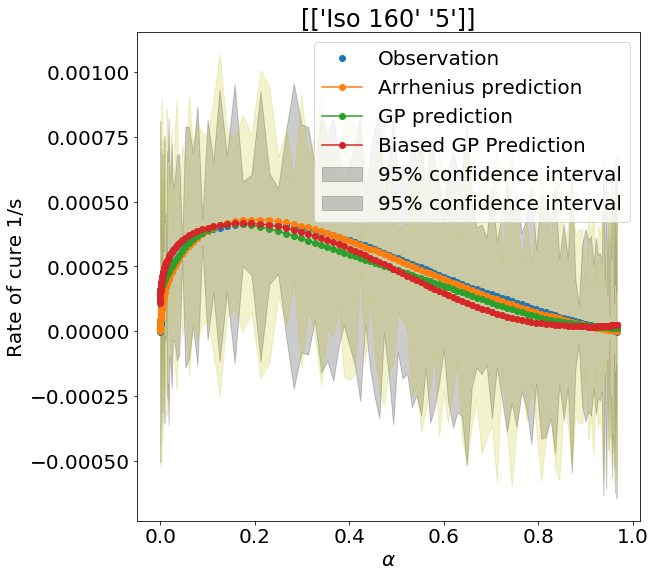

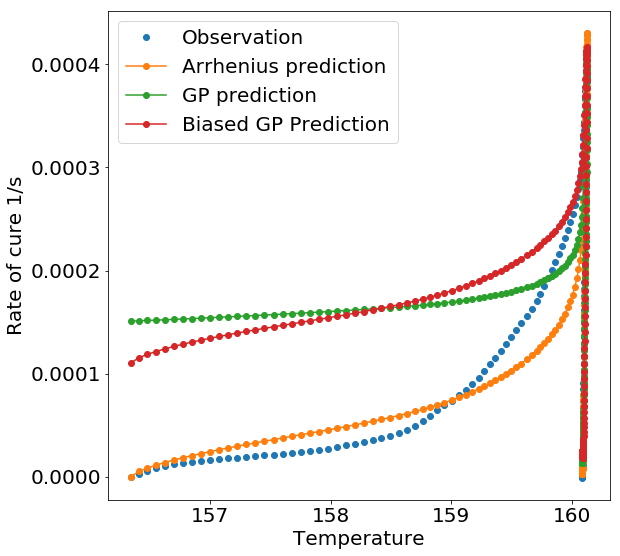

In [175]:
#Compare the manually calculated fs to the true test values
x_subsamp = np.asarray(X_test[0:])  #doomino
y_subsamp = np.asarray(y_test[0:])
fs_subsamp = np.asarray(fs_mean[0:])

y_arr = predict_Adams_Arrhenius(x_subsamp)
conf = 1.96 *0.1

plt.figure(figsize = (9, 9))
plt.title(str(test_sheet_names))
plt.xlabel(r'$\alpha$')
plt.ylabel('Rate of cure 1/s')
plt.plot(x_subsamp[:,0], y_subsamp, 'o', label = "Observation")
plt.plot(x_subsamp[:,0], y_arr, '-o', label = "Arrhenius prediction")
plt.plot(x_subsamp[:,0], fs_subsamp, '-o', label = "GP prediction")
plt.fill_between(x_subsamp[:,0], np.subtract(np.transpose(fs_subsamp),conf*fs_std)[0], np.add(np.transpose(fs_subsamp),conf*fs_std)[0], alpha=0.2, color='k', label='95% confidence interval')
fs_std = np.abs(fs_std)
fs_std_bias = np.abs(fs_std_bias)
plt.fill_between(x_subsamp[:,0], np.subtract(np.transpose(fs_subsamp),conf*np.sqrt(fs_std))[0], np.add(np.transpose(fs_subsamp),conf*np.sqrt(fs_std))[0], alpha=0.2, color='k', label='95% confidence interval')
plt.plot(x_subsamp[:,0], fs_mean_bias, '-o', label = "Biased GP Prediction")
#plt.fill_between(x_subsamp[:,0], np.subtract(np.transpose(fs_mean_bias),conf*fs_std_bias)[0], np.add(np.transpose(fs_mean_bias),conf*fs_std_bias)[0], alpha=0.2, color='y')#, label='95% confidence interval')
plt.fill_between(x_subsamp[:,0], np.subtract(np.transpose(fs_mean_bias),conf*np.sqrt(fs_std_bias))[0], np.add(np.transpose(fs_mean_bias),conf*np.sqrt(fs_std_bias))[0], alpha=0.2, color='y')#, label='95% confidence interval')
plt.legend()

plt.figure(figsize = (9, 9))
plt.xlabel('Temperature')
plt.ylabel('Rate of cure 1/s')
plt.plot(x_subsamp[:,1], y_subsamp, 'o', label = "Observation")
plt.plot(x_subsamp[:,1], y_arr, '-o', label = "Arrhenius prediction")
plt.plot(x_subsamp[:,1], fs_subsamp, '-o', label = "GP prediction")
plt.plot(x_subsamp[:,1], fs_mean_bias, '-o', label = "Biased GP Prediction")
plt.legend()

#Calculate the RMSE of each method
GP_rmse = get_rmse_error(y_subsamp, fs_mean)
Arr_rmse = get_rmse_error(y_subsamp, y_arr)
GPbias_rmse = get_rmse_error(y_subsamp, fs_mean_bias)

print('Arrhenius RMSE is', Arr_rmse)
print('GP RMSE is', GP_rmse)
print('GP with arrhenius biased mean', GPbias_rmse)

['Iso 120' '5']
Arrhenius RMSE is [5.54365181e-06]
GP RMSE is [0.00017011]
GP with arrhenius biased mean [0.00017161]
['Iso 140' '4']
Arrhenius RMSE is [8.96250381e-06]
GP RMSE is [0.00016989]
GP with arrhenius biased mean [0.00017053]
['Iso 160' '5']
Arrhenius RMSE is [2.56536847e-05]
GP RMSE is [3.31204133e-05]
GP with arrhenius biased mean [2.99186317e-05]
['Iso 180' '5']
Arrhenius RMSE is [7.11770806e-05]
GP RMSE is [0.0003697]
GP with arrhenius biased mean [0.00036708]
['Iso 120' 'Iso 140' 'Iso 160' 'Iso 180']


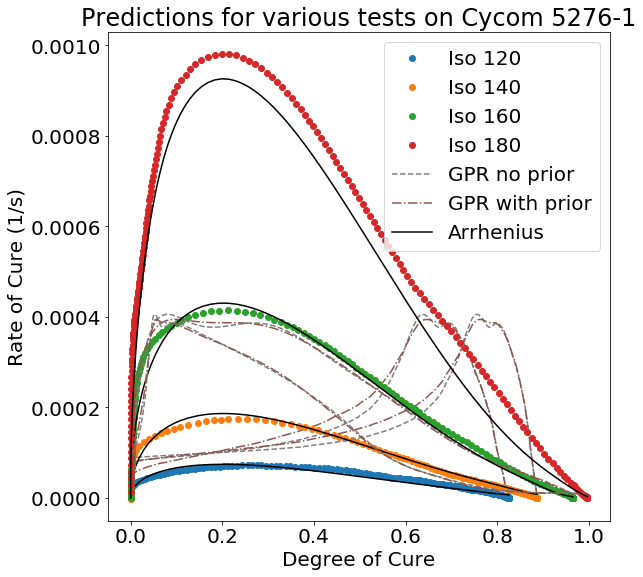

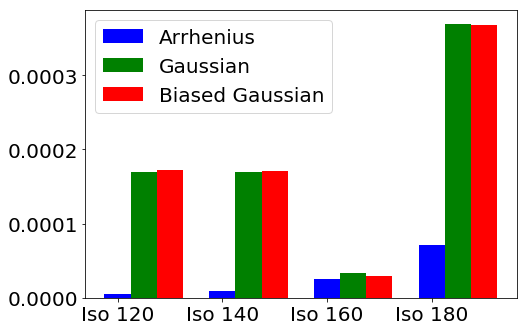

In [134]:

test_sheet_names_multiple = np.array([['Iso 120', 5], ['Iso 140', 4], ['Iso 160', 5], ['Iso 180', 5], ['Ramp Heats 2', 5], ['Ramp Heats 10', 5], ['Ramp Heats 20', 5], ['Ramp Heats 30', 5]])
test_titles = np.array([['Iso 120', 5], ['Iso 140', 4], ['Iso 160', 5], ['Iso 180', 5], ['Ramp 2', 5], ['Ramp 10', 5], ['Ramp 20', 5], ['Ramp 30', 5]])

test_sheet_names_multiple = np.array([['Iso 120', 5], ['Iso 140', 4], ['Iso 160', 5], ['Iso 180', 5]])
test_titles = np.array([['Iso 120', 5], ['Iso 140', 4], ['Iso 160', 5], ['Iso 180', 5]])

points = 200

plt.figure(figsize = (9, 9))
plt.title('Predictions for various tests on Cycom 5276-1')
plt.xlabel('Degree of Cure')
plt.ylabel('Rate of Cure (1/s)')
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'm', 'c', 'y', 'k']
Gaus_err = np.zeros(len(test_sheet_names_multiple))
Bias_err = np.zeros(len(test_sheet_names_multiple))
Arr_err = np.zeros(len(test_sheet_names_multiple))


for i in range(len(test_sheet_names_multiple)):
    test_vals = spline_5276_data(vals_5276, load_sheet_names, [test_sheet_names_multiple[i]], points)
    #print(load_sheet_names)
    #print(type(test_sheet_names_multiple[i][1]))
    X_test = np.asarray([(test_vals[input1]).T, (test_vals[input2]).T]).T
    y_test = np.atleast_2d(test_vals[output]).T
    
    #fs_mean, fs_std = calculate_predict_manual(K_t, Kt_inv, kband1, kband2, X_train, y_train, X_test, sig_err, noise_err)
    #fs_mean_bias, fs_std_bias = calculate_predict_bias(K_tbias, Kt_invbias, kband1_bias, kband2_bias, X_train, y_train, X_test, sig_err, noise_err)
    y_arr_pred = predict_Adams_Arrhenius(X_test)
    
    x_subsamp = np.asarray(X_test[0:])
    y_subsamp = np.asarray(y_test[0:])
    fs_subsamp = np.asarray(fs_mean[0:])
    fs_subsamp_bias = np.asarray(fs_mean_bias[0:])
    
    plt.plot(x_subsamp[:,0], y_subsamp, 'o', label = test_sheet_names_multiple[i][0], color = colours[i])
    if i == len(test_sheet_names_multiple)-1:
        plt.plot(x_subsamp[:,0], fs_subsamp, '--', color = 'tab:grey', label = 'GPR no prior')
        plt.plot(x_subsamp[:,0], fs_subsamp_bias, '-.', color = 'tab:brown', label = 'GPR with prior')
        plt.plot(x_subsamp[:,0], y_arr_pred, '-', color = 'k', label = 'Arrhenius')
    else:
        plt.plot(x_subsamp[:,0], fs_subsamp, '--', color = 'tab:grey')
        plt.plot(x_subsamp[:,0], fs_subsamp_bias, '-.', color = 'tab:brown')
        plt.plot(x_subsamp[:,0], y_arr_pred, '-', color = 'k')
    
    GP_rmse = get_rmse_error(y_subsamp, fs_subsamp)
    Arr_rmse = get_rmse_error(np.array(y_subsamp), np.array(y_arr_pred))
    GPbias_rmse = get_rmse_error(y_subsamp, fs_subsamp_bias)
    
    Gaus_err[i] = GP_rmse
    Bias_err[i] = GPbias_rmse
    Arr_err[i] = Arr_rmse
    
    print(test_sheet_names_multiple[i])
    print('Arrhenius RMSE is', Arr_rmse)
    print('GP RMSE is', GP_rmse)
    print('GP with arrhenius biased mean', GPbias_rmse)
    
    
legend = plt.legend(loc = '1')

X = np.arange(len(test_sheet_names_multiple))
print(test_sheet_names_multiple[:,0])
#X = test_sheet_names_multiple
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, Arr_err, color = 'b', width = 0.25)
ax.bar(X + 0.25, Gaus_err, color = 'g', width = 0.25)
ax.bar(X + 0.50, Bias_err, color = 'r', width = 0.25)

ax.set_xticks(X)
ax.set_xticklabels(test_titles[:,  0])
#ax.set_xticklabels([0,  'Iso 120', 'Iso 140',  'Iso 160', 'Iso 180'])
plt.legend(['Arrhenius', 'Gaussian',  'Biased Gaussian'])
plt.show()

NameError: name 'get_legend_handles_labels' is not defined

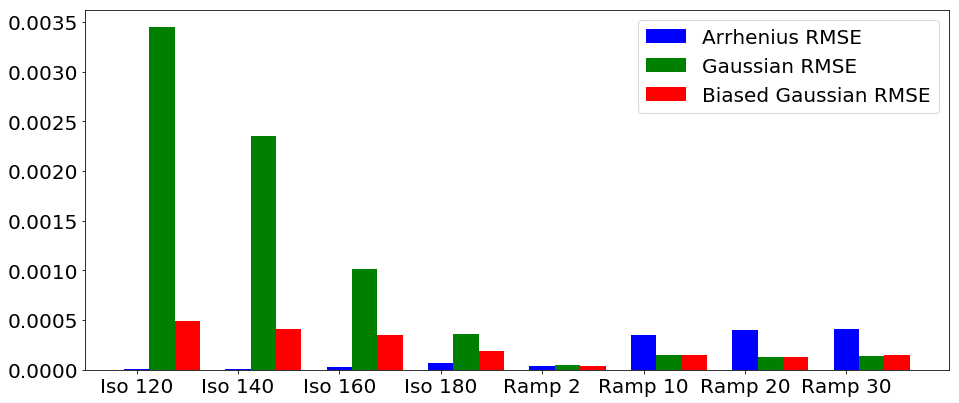

In [146]:
test_titles = np.array([['Iso 120', 5], ['Iso 140', 4], ['Iso 160', 5], ['Iso 180', 5], ['Ramp 2', 5], ['Ramp 10', 5], ['Ramp 20', 5], ['Ramp 30', 5]])

X = np.arange(len(test_sheet_names_multiple))
fig = plt.figure(figsize = (12,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, Arr_err, color = 'b', width = 0.25)
ax.bar(X + 0.25, Gaus_err, color = 'g', width = 0.25)
ax.bar(X + 0.50, Bias_err, color = 'r', width = 0.25)

ax.set_xticks((X)*1)
ax.set_xticklabels(test_titles[:,  0])
#ax.set_xticklabels([0,  'Iso 120', 'Iso 140',  'Iso 160', 'Iso 180'])
plt.legend(['Arrhenius RMSE', 'Gaussian RMSE',  'Biased Gaussian RMSE'])
plt.show()

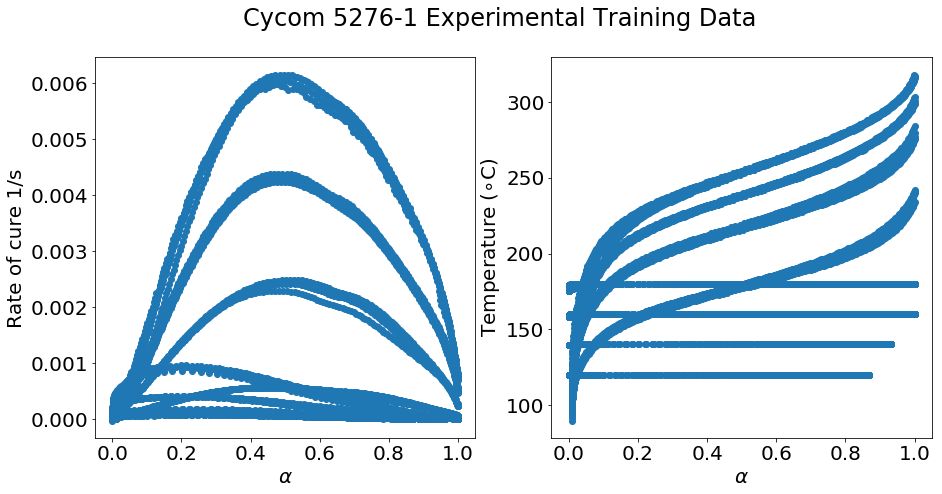

In [111]:
#This cell should show me all the training data to give an idea of where the data is dense

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))
fig.suptitle('Cycom 5276-1 Experimental Training Data')


fig.figsize = (9,9)
#ax1.set_title('Training Data on the DOC ROC plane')
ax1.set(xlabel=r'$\alpha$')
ax1.set(ylabel='Rate of cure 1/s')
#plt.plot(X_bias[:, 0], y_bias, 'o', label = 'Biased Data')
ax1.plot(X_train[:,0], y_train, 'o', label = "observation")
#plt.plot(X_train[:,0], y_train, 'o', label = "observation")


#plt.figure(figsize = (9, 9))
#ax2.set_title('Cycom 5276-1 Experimental Data')
plt.xlabel(r'$\alpha$')
plt.ylabel('Temperature ($\circ$C)')
#plt.plot(X_bias[:,0], X_bias[:,1], 'o', label = "Biased Data")
ax2.plot(X_train[:,0], X_train[:,1], 'o', label = "observation")
#plt.plot(X_train[:,0], X_train[:,1], 'o', label = "observation")


0.05
0.05
2.419
2.227
K_ts no prior
[[1.69280447e-001 5.61925118e-002 1.43105963e-002 ... 8.24195398e-097
  2.51924594e-098 5.90770207e-100]
 [1.69581313e-001 5.63203554e-002 1.43502814e-002 ... 9.97492390e-097
  3.05046269e-098 7.15697467e-100]
 [1.69330387e-001 5.62619737e-002 1.43417670e-002 ... 4.06315678e-096
  1.24311806e-097 2.91788926e-099]
 ...
 [8.57262552e-110 1.48193497e-107 1.96540510e-105 ... 1.28184415e-007
  2.04041850e-006 2.49178700e-005]
 [2.61164695e-110 4.64057994e-108 6.32612380e-106 ... 9.49288882e-008
  1.55319119e-006 1.94966089e-005]
 [7.61015864e-111 1.39314031e-108 1.95660718e-106 ... 6.82512329e-008
  1.15048347e-006 1.48784572e-005]]
K_ts
[[0.99910505 0.99854982 0.99786158 ... 0.90832348 0.9067279  0.90501422]
 [0.99910595 0.99855097 0.99786298 ... 0.90839798 0.9068025  0.9050889 ]
 [0.99910544 0.99855068 0.99786292 ... 0.90894361 0.90734737 0.90563295]
 ...
 [0.89463099 0.89695762 0.89917018 ... 0.9920325  0.99341736 0.99467127]
 [0.89413902 0.8964768  0.

0

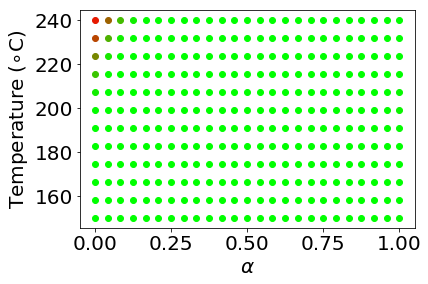

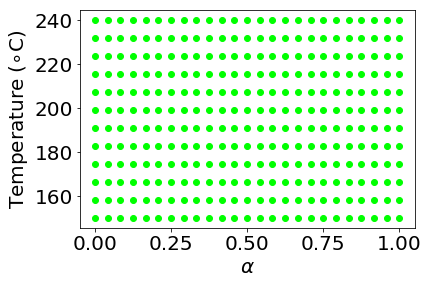

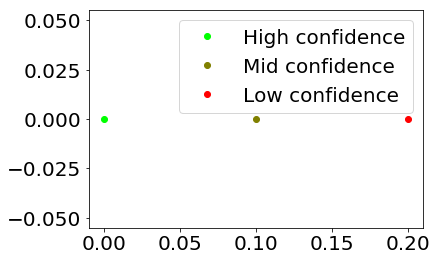

In [37]:
DOC_range = np.linspace(0, 1, 25)
Temp_range = np.linspace(150, 240, 12)

kband1 = k1_full_full_gp
kband2 = k2_full_full_gp
kband1_bias = k1_full_full
kband2_bias = k2_full_full

kband1 = 0.05
kband2 = 0.05
sig_err = 1
noise_err = 0.0001
#kband1_bias = 0.05
#kband2_bias = 0.05
#domino
#confidence_Map(K_t, Kt_inv, X_train, y_train, kband1, kband2, kband1_bias, kband2_bias, sig_err, noise_err, DOC_range, Temp_range)
confidence_Map2(X_train, y_train, kband1, kband2, kband1_bias, kband2_bias, sig_err, noise_err, DOC_range, Temp_range)

In [ ]:
print(Kt_inv)
plt.figure()
plt.imshow(Kt_inv)
plt.colorbar()
plt.show()

# idx_pos = Kt_inv > 0
# Kt_temp = np.copy(Kt_inv)
# Kt_temp[idx_pos] = 0
# plt.figure()
# plt.imshow(Kt_temp)
# plt.show()

C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\ameli\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


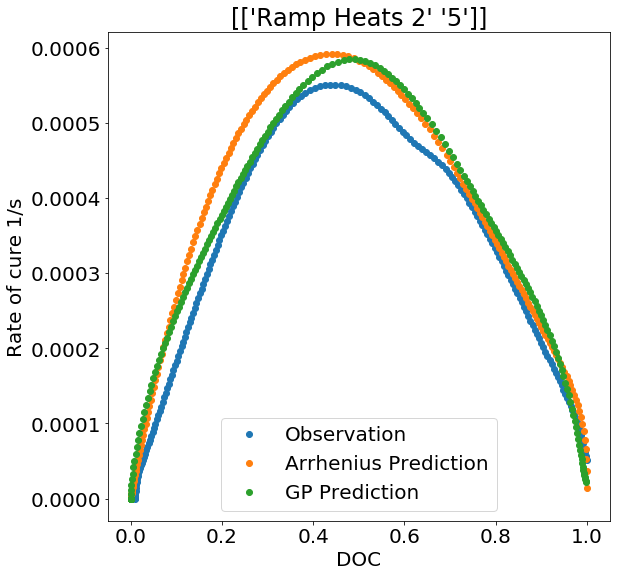

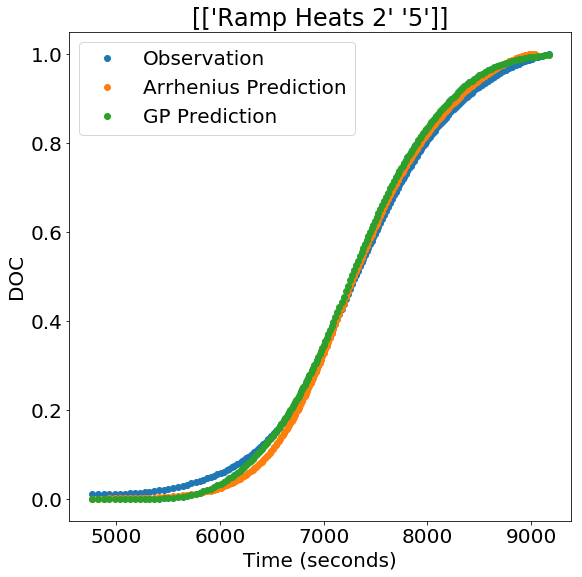

In [139]:
#Predict the cure cycle of an unknown based on the Gaussian Process model comparing
test_sheet_names = np.array([['Iso 160', 5]])
test_sheet_names = np.array([['Ramp Heats 2', 5]])
points=200
test_vals = spline_5276_data(vals_5276, load_sheet_names, test_sheet_names, points)

#Prep the inputs for the calculation of the training covariance matrix
X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T

X_test = np.asarray([(test_vals[input1]).T, (test_vals[input2]).T]).T
y_test = np.atleast_2d(test_vals[output]).T

t_step = np.asarray(test_vals[1])*60
T_step = np.asarray(test_vals[0])
ROC_step = np.asarray(test_vals[3])
DOC_step = np.asarray(test_vals[2])
DOC_0 = 0.0001

DOC_tstep, ROC_tstep = time_step_predict(T_step, t_step, DOC_0, K_t, Kt_inv, kband1, kband2, X_train, y_train, sig_err, noise_err)
DOC_Astep, ROC_Astep = time_Arr_predict(T_step, t_step, DOC_0)

plt.figure(figsize = (9, 9))
plt.title(str(test_sheet_names))
plt.xlabel('DOC')
plt.ylabel('Rate of cure 1/s')
plt.plot(DOC_step, ROC_step, 'o', label = "Observation")
plt.plot(DOC_Astep, ROC_Astep, 'o', label = "Arrhenius Prediction")
plt.plot(DOC_tstep, ROC_tstep, 'o', label = "GP Prediction")
plt.legend()

plt.figure(figsize = (9, 9))
plt.title(str(test_sheet_names))
plt.xlabel('Time (seconds)')
plt.ylabel('DOC')
plt.plot(t_step, DOC_step, 'o', label = "Observation")
plt.plot(t_step, DOC_Astep, 'o', label = "Arrhenius Prediction")
plt.plot(t_step, DOC_tstep, 'o', label = "GP Prediction")

plt.legend()


GP_DOC_rmse = get_rmse_error(DOC_tstep, DOC_step)
Arr_DOC_rmse = get_rmse_error(DOC_Astep, DOC_step)

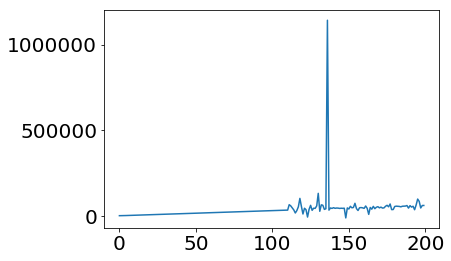

In [164]:
plt.plot(t_step)

## Section num - Visual creations

In [142]:
## GP calculation cell
len_scales = [(1E-2, 1E-1),  0.1]

total_train_sheet_names = [['Iso140-1'], ['Iso140-1', 'Iso140-2'], ['Iso140-1', 'Iso140-2', 'Iso140-3']]

gps = multi_train_gp_def(system_sep_vals, load_sheet_names, total_train_sheet_names, len_scales, points)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=[1e+06, 10]), n_restarts_optimizer=1,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [328]:
X_train = np.asarray([(system_vals[input1]).T, (system_vals[input2]).T]).T
y_train = np.atleast_2d(system_vals[output]).T

X_test = np.asarray([(test_vals[input1]).T, (test_vals[input2]).T]).T
y_test = np.atleast_2d(test_vals[output]).T

x_subsamp = np.asarray(X_test[::])
y_subsamp = np.asarray(y_test[::])

kernel = RBF(length_scale_bounds=(1e-3, 1e50))

optimizer='fmin_l_bfgs_b'
gp1 = GaussianProcessRegressor(kernel=kernel, alpha = 1e-9, n_restarts_optimizer = restarts, optimizer=optimizer)

gp1.fit(X_train, y_train)

y_pred_1, sigma_pred_1 = gp1.predict(x_subsamp, return_std=True)

conf = 1.96 *1

plt.figure(figsize = (9, 9))
plt.title('Comparison of predicted values to true test values with an optimized ls')
plt.xlabel('DOC')
plt.ylabel('Rate of cure 1/s')
plt.plot(x_subsamp[:,0], y_subsamp, 'o', label = "observation")
plt.plot(x_subsamp[:,0], y_pred_1, 'o', label = "prediction")
plt.plot(x_subsamp[:,0], y_pred_1, label = "prediction")
#plt.fill_between(x_subsamp[:,0], y_pred_1[:,0]-conf*sigma_pred_1, y_pred_1[:,0]+conf*sigma_pred_1, alpha=0.2, color='k', label='95% confidence interval')

NameError: name 'restarts' is not defined

### Single run Splining Evalutation - Section 5

In order to address issues with individual test datasets, this section allows for the pulling of one data set at a time, including full data set and subsampled (splined) dataset.

## Appendix - Section 7?

This section contains the code used which was written by rsyi on Github

In [26]:
import csv

def diffCOL(matrix):
    newMAT = []
    newROW = []
    for i in range(len(matrix)-1):
        for j in range(len(matrix[i])):
            diff = matrix[i+1][j]-matrix[i][j]
            newROW.append(diff) 
        newMAT.append(newROW)
        newROW = []
    #Stack the matrix to get xyz in columns
    newMAT = np.vstack(newMAT)
    return newMAT

def squareELEM(matrix):            
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = matrix[i][j]*matrix[i][j]
    return matrix
        
def sumROW(matrix):      
    newMAT = []
    for j in range(len(matrix)):
        rowSUM = 0
        for k in range(len(matrix[j])):
            rowSUM = rowSUM + matrix[j][k]
        newMAT.append(rowSUM)  
    return newMAT
            
def sqrtELEM(matrix):
    for i in range(len(matrix)):
        matrix[i] = math.sqrt(matrix[i])
    return matrix      

def sumELEM(matrix):
    sum = 0
    for i in range(len(matrix)):
        sum = sum + matrix[i]
    return sum

def diffMAT(matrix,denom):
    newMAT = []
    for i in range(len(matrix)):
        newMAT.append(matrix[i]/denom)
    return newMAT
    
def cumsumMAT(matrix):
    first = 0
    newmat = []
    newmat.append(first)
    #newmat.append(matrix)
    for i in range(len(matrix)):
        newmat.append(matrix[i])
    cum = 0
    for i in range(len(newmat)):
        cum = cum + newmat[i] 
        newmat[i] = cum
    return newmat
        
def divMAT(A,B):
    newMAT = []
    for i in range(len(A)):
        newMAT.append(A[i] / B[i])
    return newMAT

def minusVector(t,cumarc):
    newMAT = []
    for i in range(len(t)):
        newMAT.append(t[i] - cumarc[i])
    return newMAT
    
def replaceIndex(A,B):
    newMAT = []
    for i in range(len(B)):
        index = B[i]
        newMAT.append(A[index])
    return newMAT        
   
def matSUB(first,second):
    newMAT = []
    newCOL = []
    for i in range(len(first)):
        for j in range(len(first[i])):
            newMAT.append(first[i][j] - second[i][j])
        #newMAT.append(newCOL)
    return newMAT
    
def matADD(first,second):
    newMAT = []
    newCOL = []
    for i in range(len(first)):
        for j in range(len(first[i])):
            newMAT.append(first[i][j]+second[i][j])
        #newMAT.append(newCOL)
    return newMAT
    
def matMULTI(first,second):
    """
    Take in two matrix
    multiply each element against the other at the same index
    return a new matrix
    """
    newMAT = []
    newCOL = []
    for i in range(len(first)):
        for j in range(len(first[i])):
            newMAT.append(first[i][j]*second[i][j])
        #newMAT.append(newCOL)
    return newMAT 
    
def matDIV(first,second):
    """
    Take in two matrix
    multiply each element against the other at the same index
    return a new matrix
    """
    newMAT = []
    newCOL = []
    for i in range(len(first)):
        for j in range(len(first[i])):
            newMAT.append(first[i][j]/second[i][j])
        #newMAT.append(newCOL)
    return newMAT

def vecDIV(first,second):
    """
    Take in two arrays
    multiply each element against the other at the same index
    return a new array
    """
    newMAT = []
    for i in range(len(first)):
        newMAT.append(first[i]/second[i])
    return newMAT

def replaceROW(matrix,replacer,adder):
    newMAT = []
    if adder != 0:
        for i in range(len(replacer)):
            newMAT.append(matrix[replacer[i]+adder])
    else:
        for i in range(len(replacer)):
            newMAT.append(matrix[replacer[i]])
    return np.vstack(newMAT)
            
            
def interparc(t,px,py,*args):
    inputs = [t,px,py,args]
    #If we dont get at least a t, x, and y value we error
    if len(inputs)<3:
        print("ERROR: NOT ENOUGH ARGUMENTS")
        
    #Should check to make sure t is a single integer greater than 1
    t = t
    if (t>1) and (t%1==0):
        t = np.linspace(0,1,t)
    elif t<0 or t>1:
        print("Error: STEP SIZE t IS NOT ALLOWED")
       
    nt = len(t)
    
    px = px
    py = py
    n = len(px)
    
    if len(px) != len(py):
        print("ERROR: MUST BE SAME LENGTH")
    elif n < 2:
        print("ERROR: MUST BE OF LENGTH 2")
        
    pxy = [px,py]
    #pxy = np.transpose(pxy)
    ndim = 2
    
    method = 'linear'
    
    if len(args) > 1:
        #if isinstance(args[len(args)-1], basestring) == True:
        if isinstance(args[len(args)-1], int) == True:
            method = args[len(args)-1]
            if method != 'linear' and method != 'pchip' and method != 'spline':
                print("ERROR: INVALID METHOD")
    elif len(args)==1:
        method = args[0]
    method = 'linear'
    # Try to append all the arguments together
    for i in range(len(args)):
        #if isinstance(args[i], basestring) != True:
        if isinstance(args[i], int) != True:
            pz = args[i]
            if len(pz) != n:
                print("ERROR: LENGTH MUST BE SAME AS OTHER INPUT")
            pxy.append(pz)
    ndim = len(pxy)
    
    pt = np.zeros((nt,ndim))
    #Check for rounding errors here
    # Transpose the matrix to align with matlab codes method
    pxy = np.transpose(pxy)
    chordlen = sqrtELEM(sumROW(squareELEM(diffCOL(pxy))))
    chordlen = diffMAT(chordlen,sumELEM(chordlen))
    cumarc = cumsumMAT(chordlen)
    if method == 'linear':
        inter = np.histogram(bins=t,a=cumarc)
        tbins = inter[1]
        hist= inter[0]
        tbinset=[]
        index=0
        tbinset.append(index)
        
        for i in range(len(hist)):
            if hist[i]>0:
                index=index+hist[i]
                tbinset.append(index)
            else:
                tbinset.append(index)

        for i in range(len(tbinset)):
            if tbinset[i]<= 0 or t[i]<=0:
                tbinset[i] = 1
            elif tbinset[i]>=n or t[i]>=1:
                tbinset[i] = n-1
        #Take off one value to match the way matlab does indexing
        for i in range(len(tbinset)):
            tbinset[i]=tbinset[i]-1

        s = divMAT(minusVector(t,replaceIndex(cumarc,tbinset)),replaceIndex(chordlen,tbinset) )

        #Breakup the parts of pt
        repmat = np.transpose(np.reshape(np.vstack(np.tile(s,(1,ndim))[0]),(ndim,-1)))
        sub = np.reshape( np.vstack( matSUB( replaceROW(pxy,tbinset,1) , replaceROW(pxy,tbinset,0) ) ) , (-1,ndim) )
        multi = np.reshape( np.vstack(matMULTI( sub , repmat )) ,(-1,ndim) )
        pt = np.reshape( np.vstack( matADD( replaceROW(pxy,tbinset,0) , multi ) ) ,(-1,ndim) )
        return pt